In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from ephys_queries import db_setup_core, select_spike_times
from dotenv import load_dotenv

In [119]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"

In [120]:
df = (
    pd.read_csv(data_dir / "baseline.csv")
    .loc[lambda x: 
         (x["group_name"].isin((
            "acute_citalopram", 
            "acute_cit", 
                ))
        ) & (
         x["cluster"] != "no_baseline")]
)

In [121]:
group_names = ["acute_citalopram", "acute_cit"]
block_name = "chal"
t_before=300
fs = 30000

load_dotenv()
engine, metadata = db_setup_core()

session_names = df["session_name"].unique()
session = np.random.choice(session_names, 1)[0]

In [122]:
(
    df[["neuron_id", "session_name","cluster"]]
    .groupby(['session_name', "cluster"])
    .apply(len)
    .reset_index()
    .loc[lambda x: x["session_name"]==session]
)

,session_name,cluster,0
5,hamilton_09,fast_firing,4
6,hamilton_09,slow_irregular,4
7,hamilton_09,slow_regular,5


In [123]:
df_spikes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        group_names=group_names,
        session_names=[session],
        t_before=t_before,
        align_to_block=True
    )
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)

In [124]:
df_spikes = df_spikes.merge(df[["cluster", "neuron_id"]])

In [125]:
from spiketimes.df.conversion import df_to_list


_, slow_regs = df_to_list(df_spikes[df_spikes["cluster"] == "slow_regular"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, slow_irregs = df_to_list(df_spikes[df_spikes["cluster"] == "slow_irregular"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, ffs = df_to_list(df_spikes[df_spikes["cluster"] == "fast_firing"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

In [126]:
len(ffs)

4

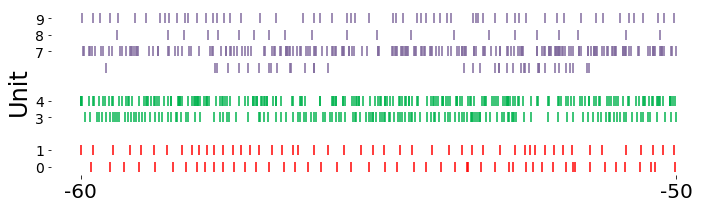

In [194]:
import matplotlib.pyplot as plt
from spiketimes.plots import grouped_raster

f, ax = plt.subplots(figsize=(10, 3))

t_start = -60
t_stop = t_start + 10

ax = grouped_raster([slow_regs[:-1:2], ffs[::3], slow_irregs],
                    ["#FF0100", "#00B34E", "#806A9D"],
               t_start=t_start, t_stop=t_stop,
                    space_between_groups=1,
               plot_kwargs={"s":90},
                   ax=ax, skip_empty=False)
ax.set_yticks(ticks=[0, 1, 3, 4, 7, 8, 9])
ax.set_yticklabels([0, 1, 3, 4, 7, 8, 9], fontsize=14)

ax.set_xticks(ticks=[-60, -50])
ax.set_xticklabels([-60, -50], fontsize=20)

ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("")

plt.tight_layout()
plt.savefig(fig_dir / "drug_raster_1.png", dpi=300, transparent=True)

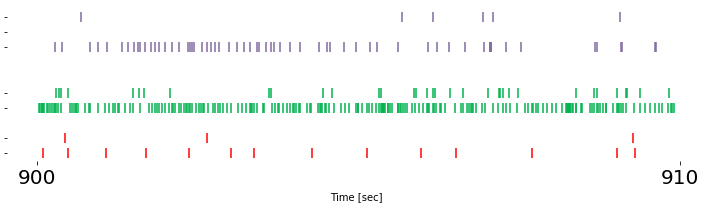

In [193]:
import matplotlib.pyplot as plt
from spiketimes.plots import grouped_raster

f, ax = plt.subplots(figsize=(10, 3))

t_start = 900
t_stop = t_start + 10

ax = grouped_raster([slow_regs[:-1:2], ffs[::3], slow_irregs],
                    ["#FF0100", "#00B34E", "#806A9D"],
               t_start=t_start, t_stop=t_stop,
                    space_between_groups=1,
               plot_kwargs={"s":90},
                   ax=ax, skip_empty=False)
ax.set_yticks(ticks=[0, 1, 3, 4, 7, 8, 9])
ax.set_yticklabels([], fontsize=14)

ax.set_xticks(ticks=[900, 910])
ax.set_xticklabels([900, 910], fontsize=20)

ax.set(frame_on=False)

ax.set_ylabel("", fontsize=24)
# ax.set_xlabel("Time [sec]", fontsize=24)

plt.tight_layout()
plt.savefig(fig_dir / "drug_raster_2.png", dpi=300, transparent=True)

In [86]:
"acute_12"

'acute_12'